In [1]:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from std_msgs.msg import String
#from deepface import DeepFace

In [2]:
import sys
#sys.path.remove('/opt/ros/melodic/lib/python2.7/dist-packages')## SI NO TIENEN ROS COMENTEN ESTA LINEA
import cv2
from cv_bridge import CvBridge, CvBridgeError
bridge = CvBridge()


In [3]:

from deepface import DeepFace

2023-03-22 22:15:31.923401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 22:15:33.234330: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-22 22:15:37.800074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/takeshi/.local/lib/python3.8/site-packages/cv2/../../lib64:/home/takeshi/catkin_extras/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/local/cuda-11.5/lib64:
2023-03-22 22:15:37.8010

In [3]:
import rospy
import face_recognition
from sensor_msgs.msg import Image , LaserScan , PointCloud2
#rospy.init_node("face_recognition")
from hmm_navigation.msg import NavigateActionGoal , NavigateActionResult   ###BETA OPTIONAL


In [4]:
from  smach_utils2 import *

ConnectionRefusedError: [Errno 111] Connection refused

In [5]:

protoFile = "/home/takeshi/openpose/models/pose/body_25/pose_deploy.prototxt"
weightsFile = "/home/takeshi/openpose/models/pose/body_25/pose_iter_584000.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

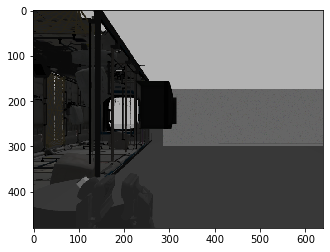

In [6]:
image=rgbd.get_image()
plt.imshow(image)

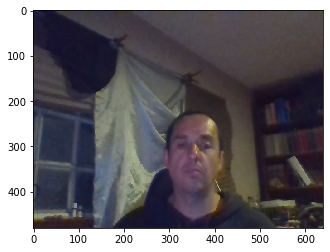

In [7]:
#rospy.sleep(5)
data = rospy.wait_for_message("/usb_cam/image_raw",Image,timeout=5) ### FOR DEBUGGING: WHEN USING ROBOT PLEASE CHANGE THIS TOPIC ACCORDINGLY
cv2_img = bridge.imgmsg_to_cv2(data)#, "bgr8")
plt.imshow(cv2_img)
image=np.copy(cv2_img)


In [8]:
frame=image
inHeight = frame.shape[0]
inWidth = frame.shape[1]


# Prepare the frame to be fed to the network
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

# Set the prepared object as the input blob of the network
net.setInput(inpBlob)

output = net.forward()

NameError: name 'net' is not defined

[ WARN] [1679539733.196257855, 2863.145000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2863.181000 according to authority unknown_publisher
[ WARN] [1679539733.196882132, 2863.145000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2863.181000 according to authority /pose_integrator
[ WARN] [1679539733.196968056, 2863.145000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2863.181000 according to authority /pose_integrator
[ WARN] [1679539733.197021549, 2863.145000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2863.181000 according to authority /pose_integrator
[ WARN] [1679539733.197078984, 2863.145000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2863.181000 according to authority /pose_integrator
[ WARN] [1679539733.429329589, 2863.255000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [ ]:
output.shape

In [ ]:
frame2 = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
frame = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

In [ ]:
H = output.shape[2]
W = output.shape[3]
threshold=0.5
# Empty list to store the detected keypoints
points = []
for i in range(10):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]
    

    # Find global maxima of the probMap.
    _, prob,_, point = cv2.minMaxLoc(probMap)
    print (point, prob)

    # Scale the point to fit on the original image
    x = (inWidth * point[0]) / W
    y = (inHeight * point[1]) / H

    if prob > threshold :
        cv2.circle(frame, (int(x), int(y)), 1, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frame, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.51, (0, 0, 255), 1, lineType=cv2.LINE_AA)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

cv2.imshow("Output-Keypoints",frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
i = 1
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (inWidth, inHeight))



#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

#plt.imshow(probMap, alpha=0.6)

In [ ]:
mask=np.where(probMap>0.3)
npmask=np.asarray(mask).T



In [ ]:
points_data=rgbd.get_points()


In [ ]:
def probmap_to_3d_mean(points_data,probMap, thres_prob=0.3):

    mask=np.where(probMap>thres_prob)
    npmask=np.asarray(mask).T

    npmask.shape
    xyz=[]
    if len (npmask)>1:
        for a in npmask:
            ix,iy=a[0],a[1]
            aux=(np.asarray((points_data['x'][ix,iy],points_data['y'][ix,iy],points_data['z'][ix,iy])))
            #print (aux)
            if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                    'reject point'
            else:
                xyz.append(aux)

    xyz=np.asarray(xyz)
    #print (xyz)
    cent=xyz.mean(axis=0)
    return cent


In [ ]:
cent=probmap_to_3d_mean(rgbd.get_points(),probMap,0.3 )

In [ ]:
tf_man.pub_static_tf(pos=cent,point_name='neck', ref= 'head_rgbd_sensor_link',)

In [ ]:
def point_2D_3D(points_data, px_y, px_x):
    ##px pixels /2D world  P1 3D world
    ## rgbd pOINTCLOUD2 numpify
    P = np.asarray((points_data[px_y, px_x]['x'], points_data[px_y, px_x]['y'], points_data[px_y, px_x]['z']))
    return P


In [ ]:
probMap
npmask= np.where(probMap<0.1,0,probMap)

In [ ]:
npmask.shape

In [ ]:
DeepFace.extract_faces(image)

In [8]:
from face_recog.msg import *

In [9]:
from face_recog.srv import *

In [10]:
### LAUNCH SERVICE OR WAIT FOREVER (VALOR MORGULIS)

rospy.wait_for_service('recognize_face')

[ WARN] [1679541249.983725099, 2570.608000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2570.651000 according to authority unknown_publisher
[ WARN] [1679541249.984643620, 2570.608000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2570.651000 according to authority /pose_integrator
[ WARN] [1679541249.984701154, 2570.608000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2570.651000 according to authority /pose_integrator
[ WARN] [1679541249.984740926, 2570.608000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2570.651000 according to authority /pose_integrator
[ WARN] [1679541249.984774793, 2570.608000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2570.651000 according to authority /pose_integrator
[ WARN] [1679541254.944814142, 2572.533000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [11]:
### LAUNCH SERVICE OR WAIT FOREVER (VALOR MORGULIS)
rospy.wait_for_service('new_face')
#rospy.wait_for_service('analyze_face')



[ WARN] [1679541272.143396880, 2578.669000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2578.712000 according to authority unknown_publisher
[ WARN] [1679541272.143679879, 2578.669000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2578.712000 according to authority /pose_integrator
[ WARN] [1679541272.143746719, 2578.669000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2578.712000 according to authority /pose_integrator
[ WARN] [1679541272.143804759, 2578.669000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2578.712000 according to authority /pose_integrator
[ WARN] [1679541272.143859822, 2578.669000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2578.712000 according to authority /pose_integrator


In [12]:
train_new_face = rospy.ServiceProxy('new_face', RecognizeFace)    
recognize = rospy.ServiceProxy('recognize_face', RecognizeFace)    
#analyze = rospy.ServiceProxy('analyze_face', RecognizeFace)    

In [13]:
req=RecognizeFaceRequest()

strings=Strings()
string_msg= String()
string_msg.data='any'
req.Ids.ids.append(string_msg)

img_msg=bridge.cv2_to_imgmsg(cv2_img)
req.in_.image_msgs.append(img_msg)
res=recognize(req)
#res = analyze(req)
res

[ WARN] [1679541276.020749652, 2580.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2580.201000 according to authority unknown_publisher
[ WARN] [1679541276.021129935, 2580.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2580.201000 according to authority /pose_integrator
[ WARN] [1679541276.021370356, 2580.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2580.201000 according to authority /pose_integrator
[ WARN] [1679541276.021630987, 2580.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2580.201000 according to authority /pose_integrator
[ WARN] [1679541276.021906023, 2580.201000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2580.201000 according to authority /pose_integrator
[ WARN] [1679541277.961448777, 2580.518000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

Ds: 
  data: [0.15294118225574493]
Angs: 
  data: [268.0, 425.0, 397.0, 296.0, 0.05307510867714882]
Ids: 
  ids: 
    - 
      data: "Jack"
    - 
      data: "Jack"

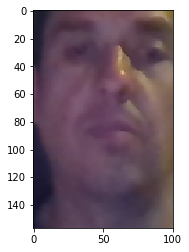

[ WARN] [1679541313.071791982, 2591.377000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2591.409000 according to authority unknown_publisher
[ WARN] [1679541313.072646128, 2591.377000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2591.409000 according to authority /pose_integrator
[ WARN] [1679541313.072719724, 2591.377000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2591.409000 according to authority /pose_integrator
[ WARN] [1679541313.072775741, 2591.377000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2591.409000 according to authority /pose_integrator
[ WARN] [1679541313.072826503, 2591.377000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2591.409000 according to authority /pose_integrator
[ WARN] [1679541314.241053090, 2591.838000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [14]:
boundRect=np.asarray(res.Angs.data).astype('int')
plt.imshow(cv2_img[boundRect[0]:boundRect[1],boundRect[3]:boundRect[2]]                )

In [15]:
name=res.Ids.ids[0].data
#talk('I found you, I Think you are .' + name)
#print(res.Angs.data)
points = rgbd.get_points()
boundRect=np.asarray(res.Angs.data).astype('int')                
trans = bbox_3d_mean(points, boundRect)
print(trans)
#############################################################################################
##############################################################################################
tf_man.pub_static_tf(pos=trans, point_name=name, ref='head_rgbd_sensor_link')

rospy.sleep(0.3)
tf_man.change_ref_frame_tf(res.Ids.ids[0].data)


try:
    trans,quat = tf_man.getTF(target_frame=name)
except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException):
    print ( 'No TF FOUND')
omni_base.move_d_to(1.5, name )
print (trans)
#head.absolute(*trans)

talk (name +'... I will lead you to the living room, please follow me')

return 'succ'

[ WARN] [1679541364.489388745, 2609.498000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2609.521000 according to authority unknown_publisher
[ WARN] [1679541364.494453431, 2609.498000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2609.521000 according to authority /pose_integrator
[ WARN] [1679541364.494541210, 2609.498000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2609.521000 according to authority /pose_integrator
[ WARN] [1679541364.494596862, 2609.498000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2609.521000 according to authority /pose_integrator
[ WARN] [1679541364.494649265, 2609.498000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2609.521000 according to authority /pose_integrator


[0.27485454 0.9254142  5.7498035 ]
header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
goal_id: 
  stamp: 
    secs: 0
    nsecs:         0
  id: ''
goal: 
  x: 4.194239668922286
  y: -0.24259575484315993
  yaw: -0.05746060553327595
  timeout: 30
  known_location: "None"


[ WARN] [1679541368.577289215, 2611.016000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2611.016000 according to authority /pose_integrator
[ WARN] [1679541368.577374999, 2611.016000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2611.016000 according to authority /pose_integrator
[ WARN] [1679541368.577444731, 2611.016000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2611.016000 according to authority /pose_integrator
[ WARN] [1679541368.577507426, 2611.016000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2611.016000 according to authority /pose_integrator
[ WARN] [1679541368.579714221, 2611.016000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2611.016000 according to authority unknown_publisher
[ WARN] [1679541401.603855363, 2621.566000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[5.691764059291292, -0.32873924124774995, 0.05264201228138055]


[ WARN] [1679541421.771381869, 2628.973000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2628.994000 according to authority /pose_integrator
[ WARN] [1679541421.771458394, 2628.973000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2628.994000 according to authority /pose_integrator
[ WARN] [1679541421.771534234, 2628.973000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2628.994000 according to authority /pose_integrator
[ WARN] [1679541421.771583826, 2628.973000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2628.994000 according to authority unknown_publisher
[ WARN] [1679541421.771631048, 2628.973000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2628.994000 according to authority /pose_integrator
[ WARN] [1679541422.459508435, 2629.284000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

SyntaxError: 'return' outside function (1925142246.py, line 26)

[ WARN] [1679541436.873461289, 2633.131000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2633.156000 according to authority /pose_integrator
[ WARN] [1679541436.873537587, 2633.131000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2633.156000 according to authority /pose_integrator
[ WARN] [1679541436.873593022, 2633.131000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2633.156000 according to authority /pose_integrator
[ WARN] [1679541436.873644673, 2633.131000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2633.156000 according to authority /pose_integrator
[ WARN] [1679541436.873912073, 2633.131000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 2633.156000 according to authority unknown_publisher
[ WARN] [1679541438.514182014, 2633.782000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

In [ ]:

robot, robotquat = tf_man.getTF('base_link')
new_yaw = (tf.transformations.euler_from_quaternion(robotquat)[2]+np.pi) 
print (new_yaw)
        # go to living room an do a 180
res = omni_base.move_base(robot[0], robot[1], new_yaw,10)


3.468965330914936
header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
goal_id: 
  stamp: 
    secs: 0
    nsecs:         0
  id: ''
goal: 
  x: 4.3634784031379015
  y: -0.2053452210437646
  yaw: 3.468965330914936
  timeout: 10
  known_location: "None"


In [19]:
bbox_3d_mean(points,boundRect )

array([0.01357047, 0.72406626, 5.7755446 ], dtype=float32)

In [ ]:
bbox_3d_mean(points[boundRect[0]:boundRect[1],boundRect[3]:boundRect[2]] )

In [ ]:
string_msg.data='Jack'
res=train_new_face(req)  ### FOR TRAINING! IF NAME IS REPETAED WILL CRASH
res

In [ ]:
type (boundRect), 

In [1]:
from smach_utils2 import *

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
points=rgbd.get_points()

In [ ]:
def bbox_3d_mean(points,bbox):
    
    xyz=[]
    bbox[0]
    for i in np.arange((int)(bbox[0]),(int)(bbox[0])+(int)(bbox[2])):
        for j in np.arange((int)(bbox[1]),(int)(bbox[1])+(int)(bbox[3])):
            aa=np.asarray(points[['x','y','z']][i,j])
            if np.isnan(np.asarray((aa['x'],aa['y'],aa['z']))).sum() ==0:                   
                xyz.append(np.asarray((aa['x'],aa['y'],aa['z'])) )
    return np.asarray(xyz).mean(axis=0)

In [ ]:
def bbox_3d_mean(points,bbox):
    
    xyz=[]

    for i in np.arange((int)(21.0),(int)(21.0)+(int)(187.0)):
        for j in np.arange((int)(178.0),(int)(178.0)+(int)(344.0)):
            aa=np.asarray(points[['x','y','z']][i,j])
            if np.isnan(np.asarray((aa['x'],aa['y'],aa['z']))).sum() ==0:                   
                xyz.append(np.asarray((aa['x'],aa['y'],aa['z'])) )

In [ ]:
x,y,z=xyzz.mean(axis=0)
x,y,z

In [ ]:
bbox=(21,178,187,344)

In [ ]:
trans=bbox_3d_mean(points,bbox)
trans

In [ ]:
trans=xyzz.mean(axis=0)
trans[2]+=600
trans

In [ ]:
points

In [ ]:
aux=(points[['x','y','z']][-20,410])
#np.isnan(aux)
aa=np.asarray(aux)
np.isnan(np.asarray((aa['x'],aa['y'],aa['z']))).sum()==0

In [ ]:
21.0, 178.0, 187.0, 344.0
for i 

aux=(points[['x','y','z']][-20,410])

In [ ]:
plt.imshow (points['x'])

In [ ]:
data=(21.0, 178.0, 187.0, 344.0)
data

In [ ]:
try:
    res=DeepFace.extract_faces(image )
    print ('face found')
    dfs = DeepFace.find(image,path_for_faces)
    print('id',dfs[0]['identity'].iloc[0].split('/')[-2])
except(ValueError): 
    print('No Face')

In [ ]:
#### DISPLAY IMAGE?#############3
#obj=res
pt1 = res[0]['facial_area']['x'],res[0]['facial_area']['y'] 
pt2=  res[0]['facial_area']['x']+res[0]['facial_area']['w'] , res[0]['facial_area']['y']+ res[0]['facial_area']['h']
img=cv2.rectangle(image, pt1,pt2, (0, 0, 255), 2)
img = cv2.putText(img, dfs[0]['identity'].iloc[0].split('/')[-2], pt1, cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255, 0, 0), 2, cv2.LINE_AA)
   


In [ ]:
plt.imshow(cv2_img)

In [ ]:
plt.imshow(img)

In [ ]:
dfs = DeepFace.find(image,path_for_faces)
dfs[0]['identity'].iloc[0].split('/')[-2]

In [ ]:

dfs = DeepFace.find(image,path_for_faces)

In [ ]:
from deepface import DeepFace

In [ ]:
objs = DeepFace.analyze(image, 
        actions = ['age', 'gender', 'race', 'emotion']
)

In [ ]:
objs

In [ ]:
objs[0]['region']

In [ ]:
objs[0]['dominant_gender'],objs[0]['dominant_race'],objs[0]['dominant_emotion'],objs[0]['age']

In [ ]:
for st in (objs[0]['dominant_gender'],objs[0]['dominant_race'],objs[0]['dominant_emotion'],objs[0]['age']):
    print (st)

In [ ]:
objs[0]['age']

In [ ]:
from face_recog.msg import *

In [ ]:
from face_recog.srv import *

In [ ]:
def train_face(image, name):
    req=RecognizeFaceRequest()
    strings=Strings()
    string_msg= String()
    string_msg.data=name
    req.Ids.ids.append(string_msg)

    img_msg=bridge.cv2_to_imgmsg(image)
    req.in_.image_msgs.append(img_msg)
    res=train_new_face(req)
    return res.Ids.ids[0].data.split(' ')[0] == 'trained'

In [ ]:
### LAUNCH SERVICE OR WAIT FOREVER (VALOR MORGULIS)

rospy.wait_for_service('recognize_face')

In [ ]:
### LAUNCH SERVICE OR WAIT FOREVER (VALOR MORGULIS)
rospy.wait_for_service('new_face')


In [ ]:
train_new_face = rospy.ServiceProxy('new_face', RecognizeFace)    
recognize = rospy.ServiceProxy('recognize_face', RecognizeFace)    

In [ ]:
req=RecognizeFaceRequest()

strings=Strings()
string_msg= String()
string_msg.data='any'
req.Ids.ids.append(string_msg)

img_msg=bridge.cv2_to_imgmsg(cv2_img)
req.in_.image_msgs.append(img_msg)
res=recognize(req)
res

In [ ]:
plt.imshow(cv2_img)

In [ ]:
req=RecognizeFaceRequest()

strings=Strings()
string_msg= String()
string_msg.data='Jack'
req.Ids.ids.append(string_msg)

img_msg=bridge.cv2_to_imgmsg(image)
req.in_.image_msgs.append(img_msg)




In [ ]:
res=train_new_face(req)  ### FOR TRAINING! IF NAME IS REPETAED WILL CRASH
res

In [ ]:
import face_recognition

In [ ]:
face_recognition.face_locations(cv2_img)

In [ ]:
###################Using Navigation to get to a Distance from this face$$

In [ ]:
listener = tf.TransformListener()
broadcaster = tf.TransformBroadcaster()
pub_goal= rospy.Publisher('/navigate/goal', NavigateActionGoal, queue_size=1)

In [ ]:
d=res.Ds.data[0]
D_to_person=0.15
pose=np.zeros(3)
pose[2]+=d - D_to_person
quat=np.zeros(4)
quat[-1]=1
    

broadcaster.sendTransform(pose, quat,rospy.Time.now(), 'face','head_rgbd_sensor_link')
for i in range (10):
    try:
        goal_pose, quat=listener.lookupTransform( 'map','face', rospy.Time(0))
        print('yes tf')
        break
    except:
        print  ('No tf')
        rospy.sleep(0.2)

In [ ]:

goal_pose
goal= NavigateActionGoal()
goal.goal.x=goal_pose[0]
goal.goal.y=goal_pose[1]

goal.goal.timeout= 10
nav_res= NavigateActionResult()
pub_goal.publish(goal)

In [ ]:
image

In [ ]:
from smach_utils2 import *

In [ ]:
res= speech_recog_server()

In [ ]:
res.data

In [ ]:
res2=train_face(image,res.data)


In [ ]:
res2.Ids.ids[0].data.split(' ')[0] == 'trained'

In [ ]:
train_face(image,res.data)

In [ ]:
req

In [ ]:

from smach_utils2 import *
from rospkg import RosPack

In [ ]:
rp = RosPack()
path = rp.get_path('config_files')

In [ ]:
path

In [ ]:
from rospkg import RosPack

rp = RosPack()
path_for_faces = rp.get_path('config_files')+'/faces_for_recognition'


In [ ]:
path_for_faces

In [ ]:
path_for_faces = rp.get_path('config_files')

In [ ]:
for person in os.listdir(path_for_faces):
    print (person)

In [ ]:
import os
os.listdir(path_for_faces)[1]

In [ ]:
omni_base.move_base(1,1,np.pi,1)

In [ ]:
print (res)

In [ ]:
robot, robotquat = tf_man.getTF('base_link')
new_yaw = (tf.transformations.euler_from_quaternion(robotquat)[2]+np.pi)
print(new_yaw)
# go to living room an do a 180
res = omni_base.move_base(robot[0], robot[1], new_yaw)

In [5]:
import human_detector

In [ ]:
#from segmentation.srv import Segmentation, SegmentationResponse 
from human_detector.srv import Human_detector ,Human_detectorResponse 

In [ ]:
cent

In [ ]:
res=Human_detectorResponse()
res.x= cent[0]
res.y= cent[1]
res.z= cent[2]

In [ ]:
hu

In [ ]:
res=human_detect_server.call()

In [ ]:
res

In [ ]:
xyz_cam=np.asarray((res.x,res.y,res.z))

In [ ]:
tf_man.pub_static_tf(pos=xyz_cam,point_name='face',ref="head_rgbd_sensor_rgb_frame")
tf_man.change_ref_frame_tf(point_name='face')

In [ ]:
omni_base.move_d_to(target_link='face')
head.to_tf('face')

In [6]:
robot, robotquat = tf_man.getTF('base_link')
new_yaw = (tf.transformations.euler_from_quaternion(robotquat)[2]+np.pi)
print(new_yaw)

3.1278336980825046


In [ ]:
res = omni_base.move_base(robot[0], robot[1], new_yaw)

header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
goal_id: 
  stamp: 
    secs: 0
    nsecs:         0
  id: ''
goal: 
  x: 0.0038766033717478393
  y: -0.001549605529100304
  yaw: 3.1278336980825046
  timeout: 30
  known_location: "None"


In [4]:
7%(2*np.pi)

0.7168146928204138

In [2]:

import numpy as np